# Copula Bayesian Networks 

In [ ]:
#Import packages
from sympy import *
import pandas as pd
import numpy as np
from scipy.stats import norm,mstats,spearmanr,multivariate_normal
from scipy import optimize
from scipy.optimize import Bounds
from collections import defaultdict 
from itertools import permutations
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#### Load Data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Data = np.load('gdrive/My Drive/DATA/DJ_data.npy')

In [ ]:
l = pd.read_table('gdrive/My Drive/DATA/Dow Jones 30.txt',header=None)
list_stocks=l.values.reshape(1,-1)[0]
names = list(list_stocks[:-1])

## Defining Various Copula Structures

### Clayton Copula Density Calculation

In [ ]:
def cl_copula(theta,u):
    d = len(u)
    s = np.sum(np.array(u)**(-theta))
    C = (s-d+1)**(-1.0/theta)
    return C

In [ ]:
f = lambdify([x,y,z,t],c, 'numpy')
f(0.5,0.3,0.2,1)

1.3823999999999999

In [ ]:
def clayton_copula_density(u,theta):
    K = len(u)
    c = (np.sum(np.array(u)**(-theta))+1-K)**(-1.0/theta-K)
    for i in range(K):
        c *= (u[i])**(-theta-1) * (1+theta*i)
    return c

### Uniform Correlation Gaussian Copula Density Calculation

In [ ]:
def g_copula(rho,u):
    K = len(u)
    sig = np.ones((K,K))*rho
    for i in range(K):
        sig[i][i] = 1
    dist = multivariate_normal(mean = np.zeros(K), cov=sig)
    v = np.array([norm.ppf(u_i) for u_i in u])
    return dist.cdf(v)

In [ ]:
def gaussian_copula_density(u,rho):
    K = len(u)
    sig = np.ones((K,K))*rho
    for i in range(K):
        sig[i][i] = 1
    sig_inv = np.linalg.inv(sig)
    I = np.eye(K)
    v = np.array([[norm.ppf(u_i) for u_i in u]])
    a = np.dot(np.dot(v,sig_inv-I),v.T)
    c = np.exp(-0.5*a)/np.sqrt(np.linalg.det(sig))
    return c[0][0]

In [ ]:
gaussian_copula_density([0.8,0.3,0.2],0.5)

0.6501828259476572

### Copula Density Ratio Calculation and Likelihood Evaluation

In [ ]:
def copula_ratio(u,p,copula = 'Gaussian'):
    if copula=="Gaussian":
        r_c = gaussian_copula_density(u,p)/gaussian_copula_density(u[1:],p)
    elif copula == "Clayton-Archimedean":
        r_c = clayton_copula_density(u,p)/clayton_copula_density(u[1:],p)
    else:
        r_c = 1
    return r_c
def llh_local(p,F,u,c_type):
    #Log-likelihood summed over the dataset for a single local copula group
    M,N = F.shape
    l=0
    for m in range(M):
        r_c = copula_ratio(F[m,u],p,copula=c_type)
        l+=np.log(r_c)
    return l
def likelihood(P,F,f,G,c_type):
    #Full log-likelihood by summing local log-likelihoods and the marginal densities
        M,N = F.shape
        l=0
        for i in range(N):
            l+=np.sum(np.log(f[:,i]))
        for i in range(len(G)):
            u = G[i]
            if len(u)>1:
                l+=llh_local(P[i],F,u,c_type)
            else:
                pass
        return l

## Copula Bayesian Network Class

#### Directed Network Graph Using Networkx

In [ ]:
class CBN:  
    def __init__(self, N, G, param_c=0.5, param_f = [1.06,-0.2], c_type = 'Gaussian'):
        self.N = N
        self.construct_directed_graph(G)
        self.num_copula = len(G)
        self.local_copula = c_type
        self.p_0 = param_c
        self.param_c = np.ones(len(G))*param_c
        self.h_const = param_f[0]
        self.h_power = param_f[1]
    def construct_directed_graph(self,G):
        #Construct DiGraph from given dependency list
        self.G = G
        self.K = len(G)
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def update_G(self):
        #Update list G and reset parameters based on updated graph
        self.G = graph_to_list(self.graph)
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
    def update_graph(self):
        #Update graph based on changed dependency list G
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in self.G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def check_acyclic(self):
        flag = nx.is_directed_acyclic_graph(self.graph)
        return flag
    def draw_network(self,names=None):
        if names==None:
            nx.draw(self.graph,with_labels=True)
        else:
            keys = sorted(self.graph.nodes)
            mapping = {}
            for i in range(len(keys)):
                mapping[keys[i]] = names[i]

            H = nx.relabel_nodes(self.graph, mapping)
            nx.draw(H,with_labels=True)
        plt.draw()
        plt.show()
    def marginal_density_estimate(self,D):
        M = len(D)
        N = len(D[0])
        self.N = N
        F = np.zeros((M,N))
        f = np.zeros((M,N))
        for i in range(N):
            x = D[:,i]
            #Winsorized cdf estimate truncation threshold
            delta = 1.0/(4*M**0.25*np.sqrt(np.log(M)*np.pi))
            x_ = mstats.winsorize(x, limits=[delta, delta]).data
            s = np.std(x)
            #Kernel pdf estimate bandwidth
            h = self.h_const*s*M**(self.h_power)
            for j in range(M):
                F[j,i] = np.sum(1.0*(x<=x_[j]))/(M+1)
                f[j,i] = (1.0/(M*h))*np.sum(np.exp(-0.5*(x-D[j,i])**2)/h**2)/np.sqrt(2*np.pi)
        self.D = D
        self.F = F
        self.f = f
        self.M = M
        return F,f 
    def mle(self):
        p_0 = self.p_0
        neg_llh_local = lambda x,F,u,c: -llh_local(x,F,u,c)
        if self.local_copula=='Clayton-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        else:
          for i in range(len(self.G)):
            u=self.G[i]
            results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',args=(self.F,u,self.local_copula), bounds = Bounds([0.01],[0.99]),options={'disp': True})
            opt_p = results.x[0]
            self.param_c[i] = opt_p
        #Update likelihood and BIC score for current network and optimal parameters
        self.likelihood = likelihood(self.param_c,self.F,self.f,self.G,self.local_copula)
        self.BIC = -2*self.likelihood+np.log(self.N)*self.K
        return self.param_c, self.likelihood, self.BIC
    

#### Helper Functions

In [ ]:
def scoring(cbn):
    opt_p,l,s = cbn.mle()
    return -s
def graph_to_list(g):
    d = {}
    for e in list(g.edges):
        if e[1] not in d.keys():
            d[e[1]] = [e[0]]
        else:
            d[e[1]].append(e[0])
    G = []
    for key in d.keys():
        l = d[key]
        full = [key]+list(l)
        G.append(full)
    return G

### Spearman's Rho Proxied Search 

In [ ]:
def SPS(D,N,p_0,copula,nbhd = 2, cur = []):
    #Spearman's rho proxy search
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    S_R = spearmanr(F,axis=0)[0]
    E = []
    for i in range(N):
        r = S_R[i]
        top = r.argsort()[-nbhd-1:][::-1]
        for j in range(nbhd):
            E.append((i,top[j+1]))
            E.append((top[j+1],i))
    E = set(E)
    print(E)
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

## Tests

In [ ]:
#Data input
N = 10
M = 1500
D = Data[:M,:N]
label = names[:N]

In [ ]:
#Example initiating a CBN class structure
G =[[0,1],[2,1]]
copula = 'Clayton-Archimedean'
p_0 = 1.0

In [ ]:
cbn = CBN(N,G,param_c = p_0, c_type = copula)

In [ ]:
#Check cycles
cbn.check_acyclic()

True

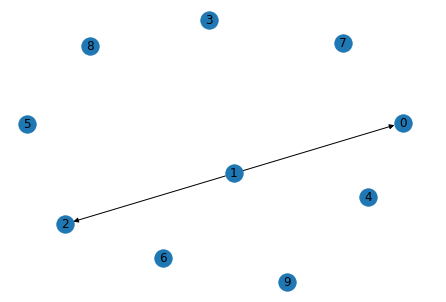

In [ ]:
cbn.draw_network()

In [ ]:
#Marginal density estimation
F,f = cbn.marginal_density_estimate(D)

In [ ]:
#Compute likelihood for current structure
likelihood([p_0,p_0],F,f,G,c_type=copula)

237022.60198835883

In [ ]:
#MLE to find current optimal parameters
cbn.mle()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.71332374649677
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -138.9499818775585
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5


(array([0.74317057, 0.65089456]), 237064.3514300517, -474124.0976899174)

In [ ]:
#Check current score
scoring(cbn)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.71332374649677
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -138.9499818775585
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5


474124.0976899174

### Performing Full Network Search Guided by Spearman's Rho Proxy

In [ ]:
#Full network 
N = 10
M = 250
D = Data[-M:,:N]
label = names[:N]

In [ ]:
copula = 'Clayton-Archimedean' # We use this copula when we have greater negative dependency in negative tail than positive. 
p_0 = 1.0

In [ ]:
cbn_prox = SPS(D,N,p_0,copula,nbhd=1,cur = [])

{(7, 3), (3, 2), (7, 0), (4, 9), (5, 6), (8, 0), (1, 4), (0, 7), (2, 3), (9, 4), (3, 7), (0, 8), (4, 1), (6, 5)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -95.28962757639738
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -34.103812847355194
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mo

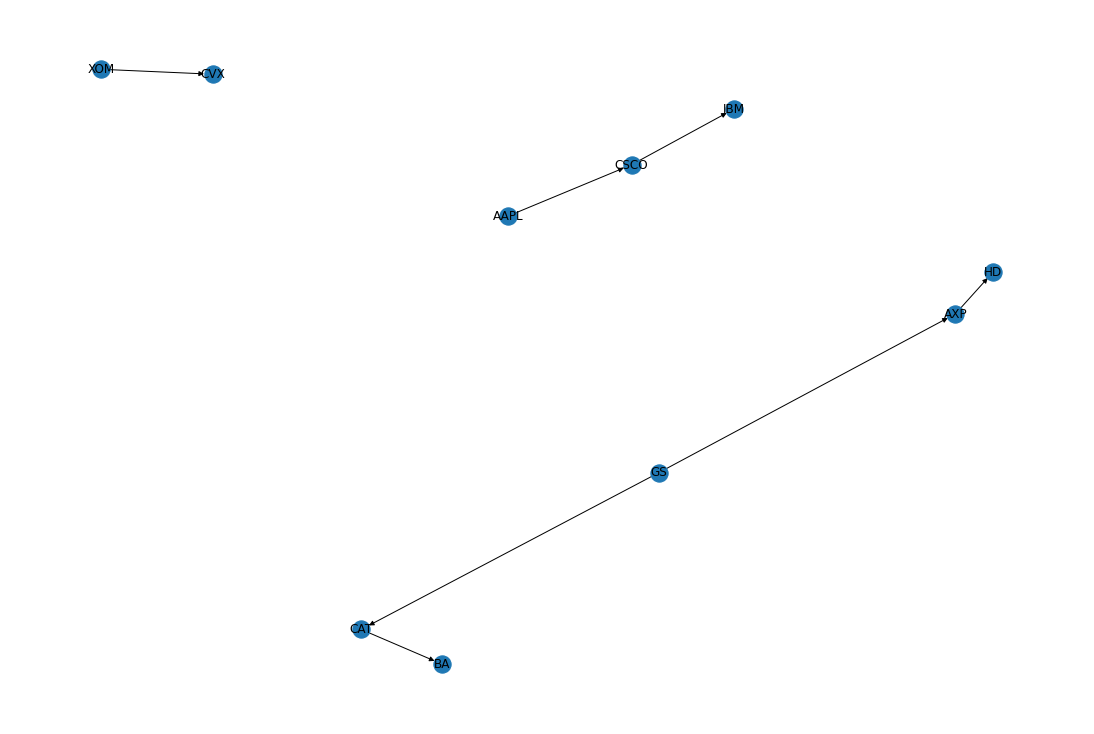

In [ ]:
plt.figure(figsize=(15,10))
nx.drawing.layout.spring_layout(cbn_prox.graph)
cbn_prox.draw_network(names=label)